# Tutorial for multiclass classification using _ImaGene_

This tutorial will show you how to perform a multiclass classification using _ImaGene_.
In this example, our goal is to classify whether a given _locus_ is under positive selection or neutrally evolving with 3 classes of selection coefficient (0,200,400 in $2N_e$ units with $N_e=10,000$) and we will be using the case of lactase persistence in European populations.
                                                                                                                                                                                                                                                                                                                                                    Please refer to the tutorial for binary classification for an in-depth explanation of the case study and main steps of the pipeline.
Here we will mostly focus on the main differences.

In [1]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import pymc3

import skimage.transform
from keras import models, layers, activations, optimizers, regularizers
from keras.utils import plot_model
from keras.models import load_model

import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pydot # optional, but required by keras to plot the model

Using TensorFlow backend.


In [3]:
%run -i ../ImaGene.py

### 1. read data from VCF file and store it into _ImaGene_ objects

In [53]:
file_LCT = ImaFile(nr_samples=198, VCF_file_name='LCT.CEU.vcf')
gene_LCT = file_LCT.read_VCF()

Here we assume we are unsure about the ancestral/derived polarisation and we switch labelling of alleles to major/minor.
We also then retain all polymorphic sites and discard columns corresponding to sites with a sample minor allele frequency of 0 (a suitable threshold is 0.005 which is < 1/198).

In [54]:
gene_LCT.majorminor()
gene_LCT.filter_freq(0.005)

0

Check the dimensions and plot it.

An object of 1 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 243, max 243, mean 243.000000, std 0.000000


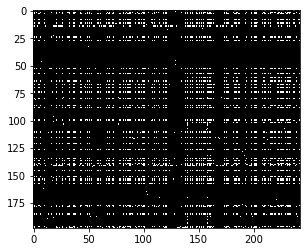

0

In [55]:
gene_LCT.summary()
gene_LCT.plot()

As an illustration, we order rows based on their genetic distance from the most frequent haplotype. 

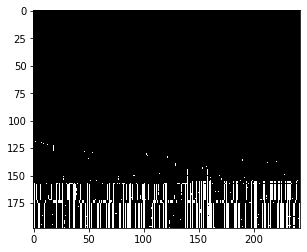

An object of 1 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 243, max 243, mean 243.000000, std 0.000000


0

In [56]:
gene_LCT.sort('rows_dist')
gene_LCT.plot()

### 2. run and process simulations to be used for training the neural network

We provide an example of parameter file called `params_multiclass` which simulates a total of 250,000 loci of 80kbp either under neutral evolution or positive selection with additive effect and allelic selection coefficients of 100, 200, 300, or 400 in $2N_e$ units with $N_e=10,000$.
All other parameters are set as in the example of binary classification.

In [11]:
import subprocess
subprocess.call("bash ../generate_dataset.sh params_multiclass.txt".split())

0

As an illustration, read the first batch of simulations to explore their content. Retain only 200 data points per class for a quick example.

In [35]:
file_sim = ImaFile(simulations_folder='/home/mfumagal/Data/ImaGene/Tutorials/Multiclass/Simulations1', nr_samples=198, model_name='Marth-3epoch-CEU')
gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=200)
gene_sim.summary()

An object of 1000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 147, max 427, mean 283.897000, std 58.408188


0

As expected we have 1000 images (200 for each one of the 5 classes).
The average number of columns is $\approx 285$.

We can check the sample allele frequency for the selected allele. Recall that we imposed selection to be acting in the middle of the region. Therefore, the targeted allele will be in position '0.5' in the _msms_ file.

Text(0, 0.5, 'Allele frequency')

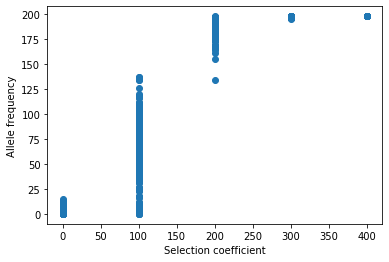

In [36]:
freqs = calculate_allele_frequency(gene_sim, 0.5)
plt.scatter(gene_sim.targets, freqs, marker='o')
plt.xlabel('Selection coefficient')
plt.ylabel('Allele frequency')

Perform the same data processing as done for LCT. As an exmaple, we resize all images to the average dimensions of (198,285).

In [37]:
gene_sim.majorminor()
gene_sim.filter_freq(0.005)
gene_sim.sort('rows_dist')
gene_sim.resize((198,285))
gene_sim.convert()

0

Suppose that we are just interested in a classification of 3 classes: 0, 200, 400.
For doing that, first we need to set `.classes` to the desired values and then we need to take a subset of the data corresponding to the desired classes only.
We can achieve these steps with the following lines.

In [38]:
gene_sim.classes = np.array([0,200,400])
gene_sim.subset(get_index_classes(gene_sim.targets, gene_sim.classes))
gene_sim.summary()

An object of 600 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 285, max 285, mean 285.000000, std 0.000000


0

We now have 600 data points corresponding to the desired classes, as expected. 

### 3. implement, train and evaluate the neural network

As discussed in the tutorial on binary classification, we need to repeat this procedure across all batches of data leaving the last one for testing. We retain 1000 images per class as an illustration.

In [39]:
i = 1
while i <= 10:

    # simluations 
    file_sim = ImaFile(simulations_folder='/home/mfumagal/Data/ImaGene/Tutorials/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')

    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=1000)
    
    # manipulate data:
    # switch to major/minor allele polarisation
    # filter our monomorphic sites
    # sort rows by genetic distance
    gene_sim.majorminor()
    gene_sim.filter_freq(0.005)
    gene_sim.sort('rows_dist')
    gene_sim.resize((198, 285))
    gene_sim.convert()
    
    # use only classes 0,200,400
    gene_sim.classes = np.array([0,200,400])
    gene_sim.subset(get_index_classes(gene_sim.targets, gene_sim.classes))

    # randomise data
    gene_sim.subset(get_index_random(gene_sim))

    # convert targets to categorical data
    gene_sim.targets = to_categorical(gene_sim.targets)
    
    # at first iteration we build the model 
    if i == 1:

        model = models.Sequential([
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid', input_shape=gene_sim.data.shape[1:]),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Flatten(),
                    layers.Dense(units=128, activation='relu'),
                    layers.Dense(units=len(gene_sim.classes), activation='softmax')])
        model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

        net_LCT = ImaNet(name='[C32+P]+[C64+P]x2+D128')

    # training for iterations from 1 to 9
    if i < 10:
        score = model.fit(gene_sim.data, gene_sim.targets, batch_size=32, epochs=1, verbose=0, validation_split=0.10)
        net_LCT.update_scores(score)
    else:
        # testing for iteration 10
        net_LCT.test = model.evaluate(gene_sim.data, gene_sim.targets, batch_size=None, verbose=0)
        net_LCT.predict(gene_sim, model)

    i += 1

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [40]:
# save final (trained) model
model.save('/home/mfumagal/Data/ImaGene/Tutorials/Data/model.multi.h5')

# save testing data
gene_sim.save('/home/mfumagal/Data/ImaGene/Tutorials/Data/gene_sim.multi')

# save network
net_LCT.save('/home/mfumagal/Data/ImaGene/Tutorials/Data/net_LCT.multi')

0

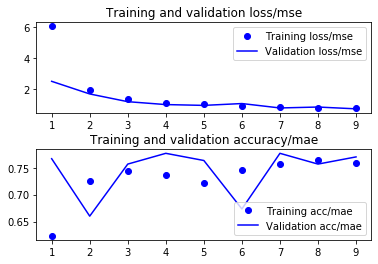

0

In [41]:
# assess the training
net_LCT.plot_train()

In [42]:
# print the testing results [loss, accuracy]
print(net_LCT.test)

[0.7108120611508687, 0.7703333333333333]


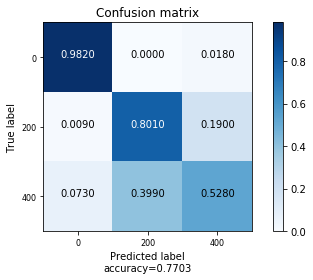

0

In [43]:
# plot a confusion matrix (on the last gene_sim object which represents the testing data)
net_LCT.plot_cm(gene_sim.classes)

### 4. deploy the trained network on your genomic data of interest

Finally we use the trained network to predict the class of natural selection on our locus of interest.
First we need to resize our real data to match the data used for training.
After that, we need to convert the data into the required format.

In [57]:
gene_LCT.resize((198,285))
gene_LCT.convert()
gene_LCT.summary()

An object of 1 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 285, max 285, mean 285.000000, std 0.000000


0

The output of this command will give us the class scores (0, 200, 400).

In [59]:
model.predict(gene_LCT.data, batch_size=None)

array([[4.2103275e-05, 9.1548377e-01, 8.4474117e-02]], dtype=float32)